# Imbalanced data and distributed computing

### Jakub Ševcech, Róbert Móro

IAU, 13.12.2018


## You can send us feedback here: https://tinyurl.com/iau2018-19

## You can ask questions here http://slido.com#iau2018-w13

# 1. How to solve problems with imbalanced datasets

# 2. Distributed computing

# 3. Review of data processing process

# 4. Questions and broader discussion
> ## - Project finalization
> ## - What to expect on the exam
> ## - ...


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.svm import LinearSVC

In [2]:
plt.rcParams['figure.figsize'] = 9, 6

# Imbalanced  datasets

The code of examples was partially adapted from here https://imbalanced-learn.org


## Let's generate some data

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=3,
                               n_clusters_per_class=1,
                               weights=[0.05, 0.07, 0.88],
                               class_sep=1.5, random_state=0)

In [4]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([ 53,  74, 873], dtype=int64))

In [5]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    colors = ['purple', 'cyan', 'yellow']
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    for i in range(3):
        ax.scatter(X[y==i, 0], X[y== i, 1], alpha=0.8, edgecolor='k', label=i, c=colors[i])
    ax.legend()

## When we have an imbalanced dataset, the classification model focuses more on the majority class

In the case of SVM on the picture below this means that the majority class pulled decision boundary at the expanse of other classes.


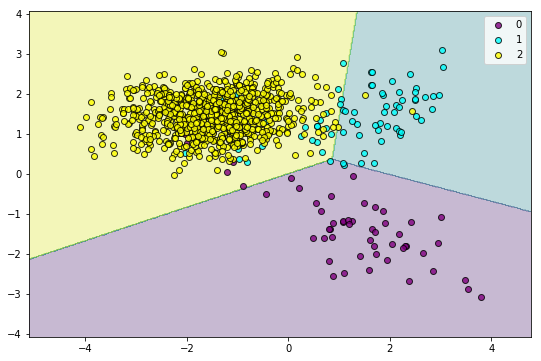

In [6]:
clf_f = LinearSVC().fit(X, y)
fig, ax = plt.subplots()
plot_decision_function(X, y, clf_f, ax) # the function is defined above, but the implementation itself is not important right now

## Some algorithms allow to set the class weight and thus counter th imbalance 

C:\Users\sevo_\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


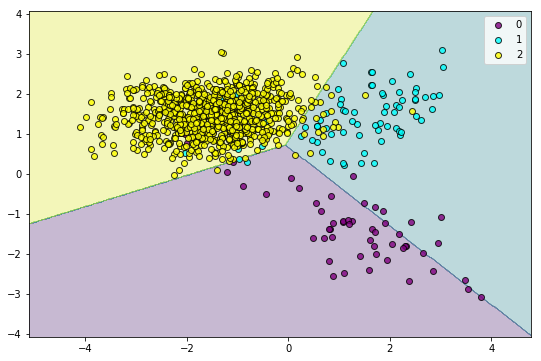

In [7]:
clf = LinearSVC(class_weight={0: 1000, 1:80, 2:5}).fit(X, y)

fig, ax = plt.subplots()
plot_decision_function(X, y, clf, ax)

## The simples, but not always the best solution is to set balanced class weight

Inversionaly proportional weight to the number of instances of the class

n_samples / (n_classes * np.bincount(y))

total number of samples / number of classes * vector of numbers of instances for every class


C:\Users\sevo_\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


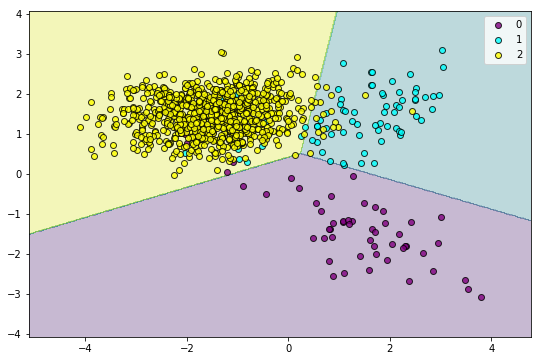

In [8]:
clf = LinearSVC(class_weight='balanced').fit(X, y)

fig, ax = plt.subplots()
plot_decision_function(X, y, clf, ax)

# Undersampling

Decrease the number of instances of the majority class (or classes with too many instances)

A lot of approaches trying for example to conserve important instances or conserve uniform coverage of the attribute space. The simplest approach is to do it at random.

Use undersampling with caution. You are losing potentially important data. However, sometimes it is necessary.


# Random undersampling

documentation of the implementation from the imblearn libary: https://imbalanced-learn.org/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler


In [9]:
!pip install --user imblearn

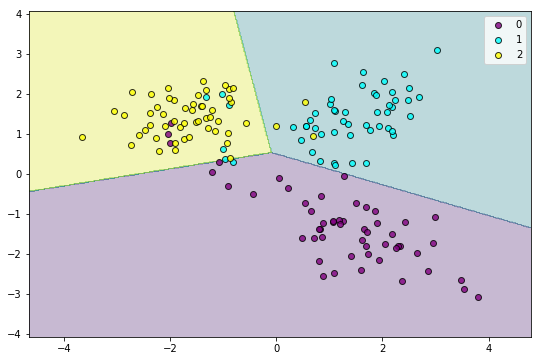

In [10]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_sample(X, y)

clf_r = LinearSVC().fit(X_res, y_res)

fig, ax = plt.subplots()
plot_decision_function(X_res, y_res, clf_r, ax)

Various strategies. For example decreasing the number of instances of a majority class or decreasing to equal number of instances for every class.

In [11]:
np.unique(y_res, return_counts=True)

(array([0, 1, 2]), array([53, 53, 53], dtype=int64))

## Undersampling trying to conserver data coverage

Text(0.5, 1.0, 'ClusterCentroids undersampling')

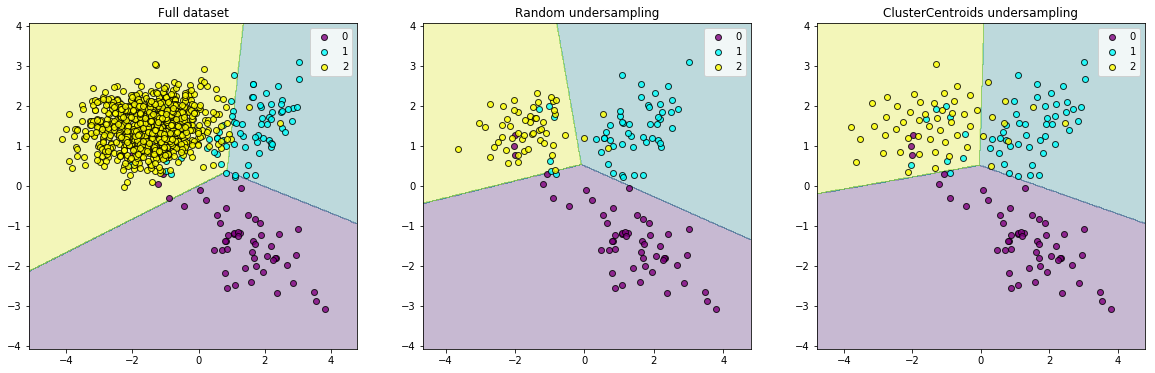

In [12]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=42)
X_cc, y_cc = cc.fit_sample(X, y)
clf_cc = LinearSVC().fit(X_cc, y_cc)

fig, ax = plt.subplots(1, 3, figsize=(20,6))
plot_decision_function(X, y, clf_f, ax[0])
ax[0].set_title('Full dataset')
plot_decision_function(X_res, y_res, clf_r, ax[1])
ax[1].set_title('Random undersampling')
plot_decision_function(X_cc, y_cc, clf_cc, ax[2])
ax[2].set_title('ClusterCentroids undersampling')

# Often more interesting method is Oversampling

Increasing the number of instance for classes with low number of observations

Again, the simplest approach is random


Text(0.5,1,'Original')

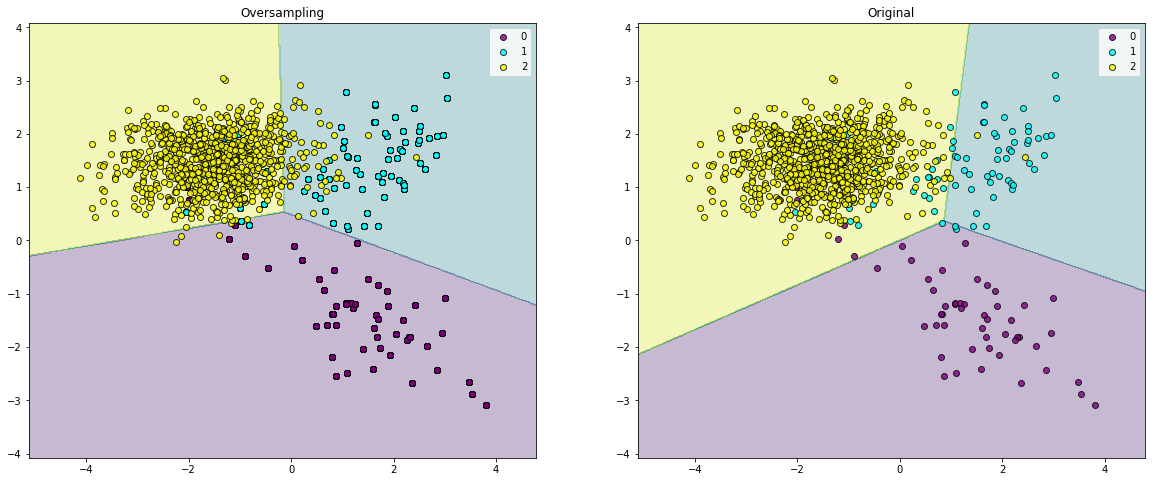

In [127]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_sample(X, y)

clf1 = LinearSVC().fit(X_res, y_res)
clf2 = LinearSVC().fit(X, y)

fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_decision_function(X_res, y_res, clf1, ax[0])
ax[0].set_title('Oversampling')
plot_decision_function(X, y, clf2, ax[1])
ax[1].set_title('Original')

## Random oversampling randomly selects with replacement from the original set. On the picture you can see darker points as repeated samples are drawn multiple times on the same location

# Attention!

When using random oversampling and you split data to train and test (valid to cross validation also).  

If you oversample first and then split the data, you could get the same instances in train and test data. test data would then not provide correct estimate on accuracy on new data as it contains exact copies of some train data. Use oversampling after splitting the data.

# There are some more sophisticated methods, that try to create new, similar instances

Eg.: SMOTE


Text(0.5,1,'Original')

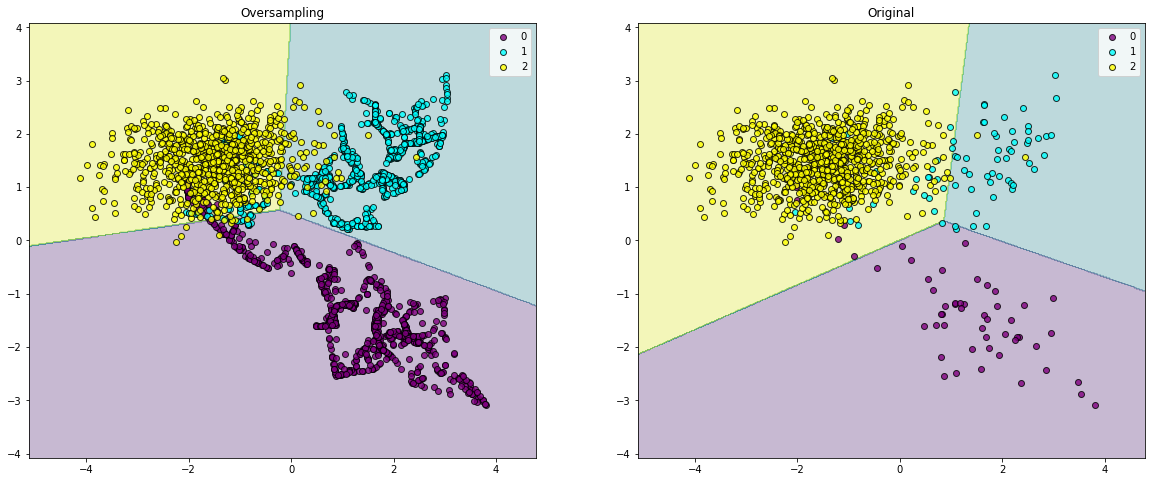

In [128]:
from imblearn.over_sampling import SMOTE

sos = SMOTE(random_state=42)
X_res, y_res = sos.fit_sample(X, y)

clf1 = LinearSVC().fit(X_res, y_res)
clf2 = LinearSVC().fit(X, y)

fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_decision_function(X_res, y_res, clf1, ax[0])
ax[0].set_title('Oversampling')
plot_decision_function(X, y, clf2, ax[1])
ax[1].set_title('Original')

## SMOTE tries to select random similar instances and from them create new ones by averaging the original ones

# Possibilities to solve the problem of imbalanced datasets 

* Class weight directly in the learning algorithm (class_weight)
* Undersampling
* Oversampling 
> * Random oversampling
> * SMOTE

Attention on overflowing of training examples into the test sample when using oversampling. 

# Distributed computing

[12_distributed_computing.ipynb](12_distributed_computing.ipynb)


# Review of data processing process

In the 4th lecture, we showed you the process of data processing


<img src="../04/ML_Workflow.PNG" alt="ML workflow" style="width: 600px;"/>


# This process is described also by CRISP-DM workflow

Cross-industry standard process for data mining

It describes the same iterative process as we did during the labs.

What is important is, that it is an open standard on data analysis and data mining process. It is incremental and iterative (continuous cyclical improvements) 

<img src="img/CRISP-DM_Process_Diagram.png" alt="CRISP" style="width: 500px;"/>


# But you can summarize it also like this :)
<img src="img/machine_learning.png" alt="machine learning" style="width: 400px;"/>

# What to take from this lecture

* There are multiple means to solve the problem of imbalanced classes: class weight, undersampling, oversampling.
* For every means to solve imbalanced data problems, there are many specific solutions
* When working with a lot of data, I don't have to be limited by the computational power of a single computer. There are a lot of tools to work with big amounts data in a distributed fashion.
* There is a lot of tools and they are rather narrowly specialized. 
* Distributed work with data does not have to be different on the first sight from work with local daatset. On the background, there is happening a lot of things.


# Exam

https://docs.google.com/presentation/d/1S2rp9YIhMaIzQ9PNuk6UGMohpAl2K6lQXrDEsooYBoE/edit?usp=sharing